# Getting the data
In this section, we are getting the data from [github](https://raw.githubusercontent.com/prasertcbs/basic-dataset/master/Airplane_Crashes_and_Fatalities_Since_1908.csv) and then writing it to our own csv file.


In [ ]:
import requests
dataset_url = "https://raw.githubusercontent.com/prasertcbs/basic-dataset/master/Airplane_Crashes_and_Fatalities_Since_1908.csv"
response = requests.get(dataset_url)
with open("Airplane_Crashes_and_Fatalities_Since_1908.csv", "wb") as csv:
  if response.content.endswith(b'\n'):
    csv.write(response.content[:-1])
  else:
    csv.write(response.content)

The csv generated now contains the data of the plane crashes through the years **1908** to **2009**.

## Get Missing Data
This subsection includes getting the missing data from the year **2010** to **2021** from this [database](https://http://planecrashinfo.com/database.htm).

In [ ]:
from bs4 import BeautifulSoup
import re, requests, datetime
 
url = "http://planecrashinfo.com"
 
main_page = requests.get(url + '/database.htm')
main_soup = BeautifulSoup(main_page.content, "html.parser")

csv = open("Airplane_Crashes_and_Fatalities_Since_1908.csv", "a+")
# csv.write("Date,Time,Location,Operator,Flight #,Route,Type,Registration,cn/In,Aboard,Fatalities,Ground,Summary\n")
 
pages = []
crash_links = []
 
def write_data(data):
  try:
      date = datetime.datetime.strptime(data[0], "%B %d, %Y") 
      #Date Format: mm/dd/yyyy
      data[0] = date.strftime("%m/%d/%Y")   
  except: data[0] = ''

  try:
      int(data[1])
      #Time Format: hh:mm
      data[1] = data[1][:2] + ':' + data[1][2:]
  except Exception as e:
          pass

  # Remove some errors from scraped data
  data[-1] = data[-1].replace('\n','')
  data[-1] = data[-1].replace("\"",'')
  data[2] = f'\"{data[2]}\"'
  data[5] = f'\"{data[5]}\"'
  data[-1] = f'\"{data[-1]}\"'

  # print(data[0])
  csv.write('\n' + ','.join(data))

Getting crash report pages from the individual links through the dates.

In [ ]:
for year in range(2010, 2022):
      try:
          ext = main_soup.find('a', text=str(year))["href"]
          page = requests.get(url+ext)
          soup = BeautifulSoup(page.content, "html.parser")
          crash_links += [f"{url}/{year}/{a['href']}" for a in soup.find_all('a')]
      except Exception as e:
          pass

Writing the perceived data to our csv.

In [ ]:
for link in crash_links:
  try:
    page = requests.get(link)
    soup = BeautifulSoup(page.content, "html.parser")
    columns = soup.find_all('tr')[1:]
    data = [c.find_all('td')[1].find('font').get_text() for c in columns]
    data = [d.split('\xa0')[0] for d in data]
    # print(len(data)) 
    write_data(data)
  except: continue
csv.close()

Now that we have written the data to our csv, it is time to analyze the extracted data.

# Importing Important Libraries
Importing all the required libraries to our ipynb. Some of which are:


1.   Matplotlib - for plotting graphs.
2.   Numpy - for calculation and data structures.
3.   Pandas - for making dataframes.

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
from IPython.display import display, HTML
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from scipy.stats import f_oneway

plt.style.use('seaborn-white')

pd.options.mode.chained_assignment = None 

# Data Cleaning
In this section, we clean the data from any invalid ascii characters and change the NaN values to null strings and 0 according to their datatype.

In [ ]:
dataset = pd.read_csv("Airplane_Crashes_and_Fatalities_Since_1908.csv")

objects = ['Location', 'Operator', 'Route', 'Type', 'Registration', 'cn/In', "Summary"]
for o in objects:
  dataset[o].fillna('', inplace=True)

# for Aboard
dataset['Aboard'].fillna(0, inplace=True)  #Replace Nan with 0

# for Fatalities
dataset['Fatalities'].fillna(0, inplace=True)  #Replace Nan with 0

# for Flight Number
dataset['Flight #'] = pd.to_numeric(dataset['Flight #'], errors='coerce') #Convert 'Flight #' Column to float
dataset['Flight #'].fillna(0, inplace=True)  #Replace NaN with empty string

# for Ground
dataset['Ground'] = pd.to_numeric(dataset['Ground'], errors='coerce') #Convert Ground Column to float
dataset['Ground'].fillna(0, inplace=True)  #Replace NaN with 0

dataset.dtypes


Date             object
Time             object
Location         object
Operator         object
Flight #        float64
Route            object
Type             object
Registration     object
cn/In            object
Aboard          float64
Fatalities      float64
Ground          float64
Summary          object
dtype: object

# Analyzing the data
In this section, we will be analyzing as well as visualizing the most important attribute of the dataset i.e ***The Number of Deaths Per Annum***.

## Fatalities throughout the years till date
The year is extracted from the given Date column using Python's `datetime` for the x axis. Here 2 graphs are merged, one providing number of fatalities in every plane crash, and another showing the mean number of fatalities for a year.

Text(1977.0, 583.0, 'Pan American World Airways / KLM 1977')

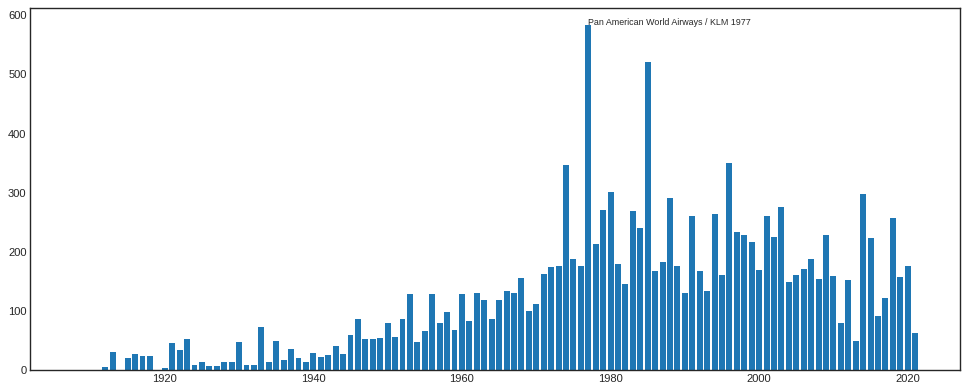

In [ ]:
data = {'years': [datetime.strptime(d, "%m/%d/%Y").year for d in dataset["Date"]],
        'fatalities': dataset["Fatalities"]}
df_year = pd.DataFrame(data)
plt.figure(figsize=(15, 6), dpi=80)

#Fatalities per crash
plt.bar(df_year['years'], df_year['fatalities'])
highest_bar = df_year.sort_values(by='fatalities', ascending=False).iloc[0]
x, y = (highest_bar['years'], highest_bar['fatalities'])
plt.text(x, y, f"{dataset['Operator'][highest_bar.name]} {int(x)}", fontdict=dict(fontsize=8))

#Average per year
# avg_data = df_year.groupby('years').mean()
# plt.bar(avg_data.index, avg_data['fatalities'])

As we can see from the bar graph above, we can see that the blue graph indicates the plane crash with the most fatalities in its respective year. The orange graph indicates the average number of fatalities which occured that year.

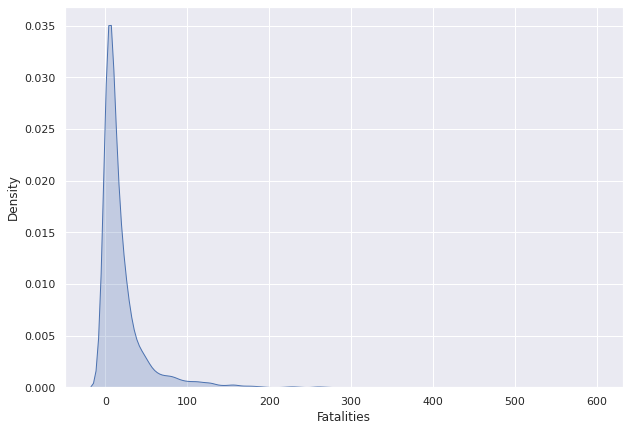

In [ ]:
sns.set(rc={'figure.figsize':(10, 7)})
sns.kdeplot(data=dataset['Fatalities'], shade=True)

As we can see above, the distribution for the Fatalities is a left-tailed distribution which indicates that most of the accidents which resulted in deaths are in the range from 0-50.

## Calculating some basic statistics
In this section, we calculate some basic overall statistics of the 3 main attributes which represent the people on board, the fatalities caused by the accident and the people who died on the ground due to the crashed airplane.

In [ ]:
data = dataset[['Aboard', 'Fatalities', 'Ground']]
data.describe()

,Aboard,Fatalities,Ground
count,5517.000000,5517.000000,5517.000000
mean,27.923328,20.365779,1.561537
std,43.752747,33.888312,52.650452
min,0.000000,0.000000,0.000000
25%,5.000000,3.000000,0.000000
50%,13.000000,9.000000,0.000000
75%,30.000000,23.000000,0.000000
max,644.000000,583.000000,2750.000000


## Word Cloud for the Summary column

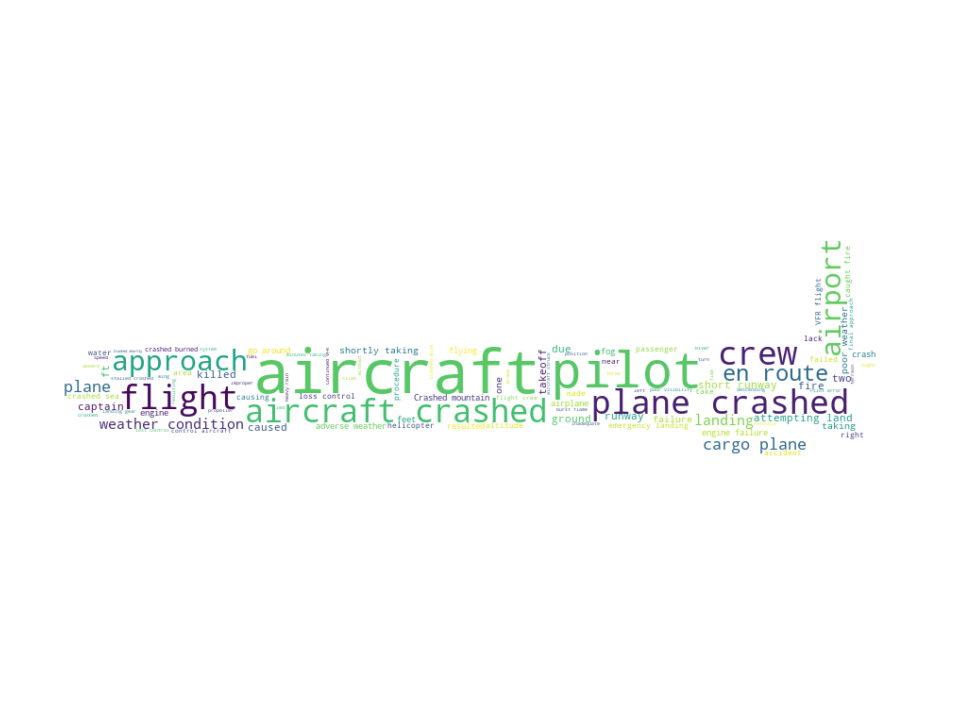

In [ ]:
def transform_format(val):
    if val == 0:
        return 255
    else:
        return val

text = "".join(dataset['Summary'].tolist())

try:
  mask = np.array(Image.open("/content/plane_mask.png"))
except:
  mask = np.zeros((500,1000))

wordcloud = WordCloud(stopwords=STOPWORDS,
               mask=mask, background_color="white",
               max_words=100, max_font_size=64,
               random_state=42).generate(text)

plt.figure(figsize=(25,13))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Finding reasons for crashes
In this sub-section, we find and graph the reasons due to which most accidents occured. 
We used the summary column to find keywords such as Crash, Collision etc.

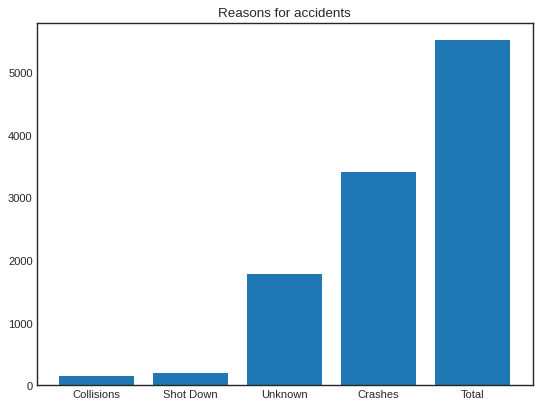

In [ ]:
summaries = dataset['Summary'].tolist()
crashes = [s for s in summaries if 'crash' in str(s).lower()]
collisions = [s for s in summaries if 'collision' in str(s).lower()]
shot_downs = [s for s in summaries if 'shot' in str(s).lower()]

cols = ["Collisions", "Shot Down", "Unknown", "Crashes", "Total"]
values = [len(collisions), len(shot_downs), len(summaries) - len(crashes) - len(collisions) - len(shot_downs), len(crashes), len(summaries)]

index = [1, 2, 3, 4, 5]

df = pd.DataFrame({'Sno': index, 'Reason': cols,'Count': values})
df = df.set_index('Sno')        # for numbering the reasons

plt.figure(figsize=(8, 6), dpi=80)

# Bar chart for the reasons
plt.title("Reasons for accidents")
plt.bar(df['Reason'], df['Count'])
plt.show()

By observing the above bar graph, it can be visualized that most accidents occured due to crashing on the ground, followed by being shot down. The rarest and deadliest accidents are collisions.

## Plane types with most crashes


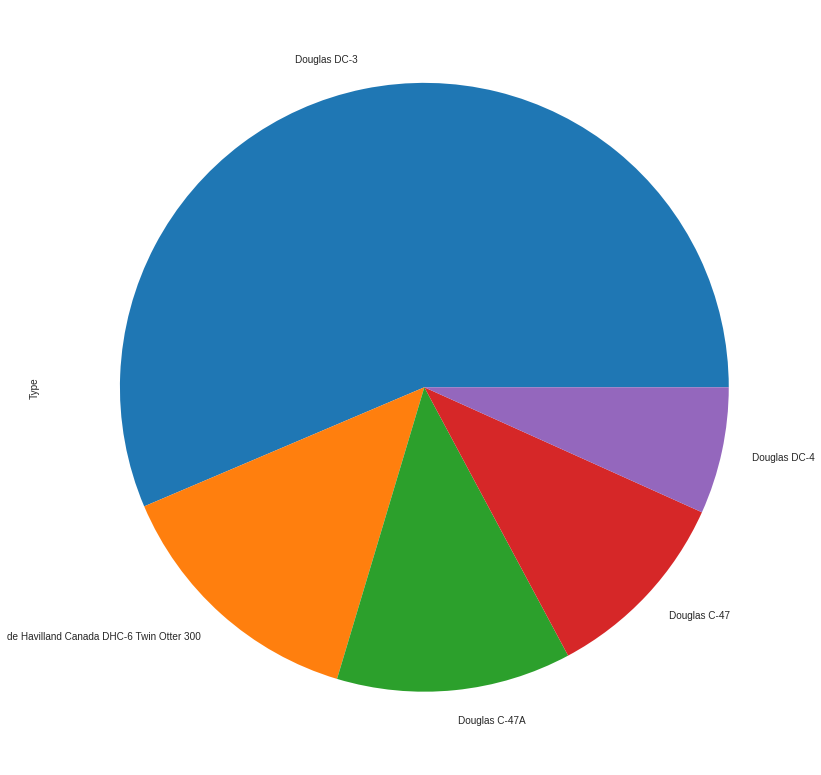

In [ ]:
#top 5 Types of airplanes which had accident

crashTypes = dataset['Type'].value_counts()

totalFlights = len(dataset['Type'].tolist())
topCrashes = crashTypes[:5]
otherCrashes = totalFlights-sum(topCrashes)
x = pd.Series([otherCrashes], index=['Others'])
x.add_prefix("Others")
N = topCrashes.append(x)
# print(N)


topCrashes.plot(kind='pie', figsize=(10, 10))


The above graph indicates that the Douglas aircrafts had the most crashes, more than a third of which were warplanes, used during the World War 2.

The Douglas manufactured planes take the spot for highest rate of crashes ever. This is because they were used in WW2 as bombers. Almost 30,000 aircrafts were produced during 1942 - 1945.

# Some Major Box Plots
In this section, we generated some box plots for some of the important columns in the dataset.

## Box plot for Fatalities

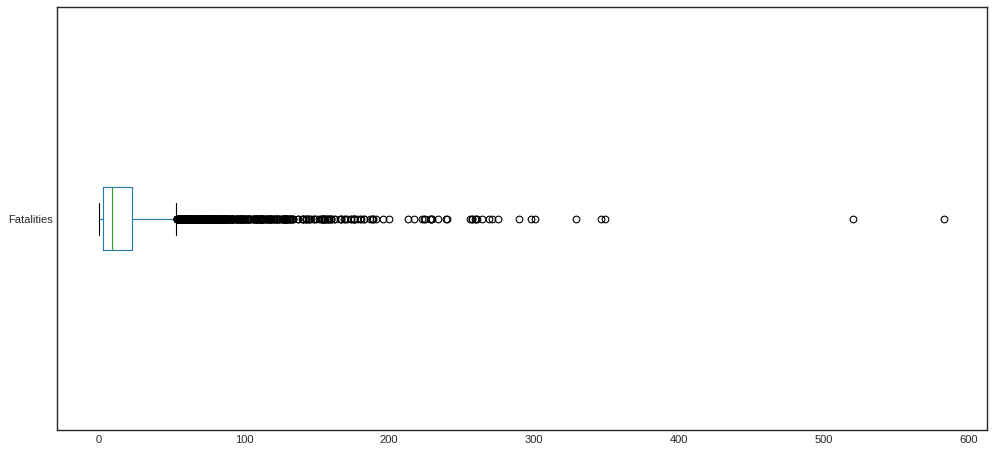

In [ ]:
plt.figure(figsize=(15, 7), dpi=80)
dataset["Fatalities"].plot(kind='box', vert=False, fig=(14,10))

## Box Plot for Aboard

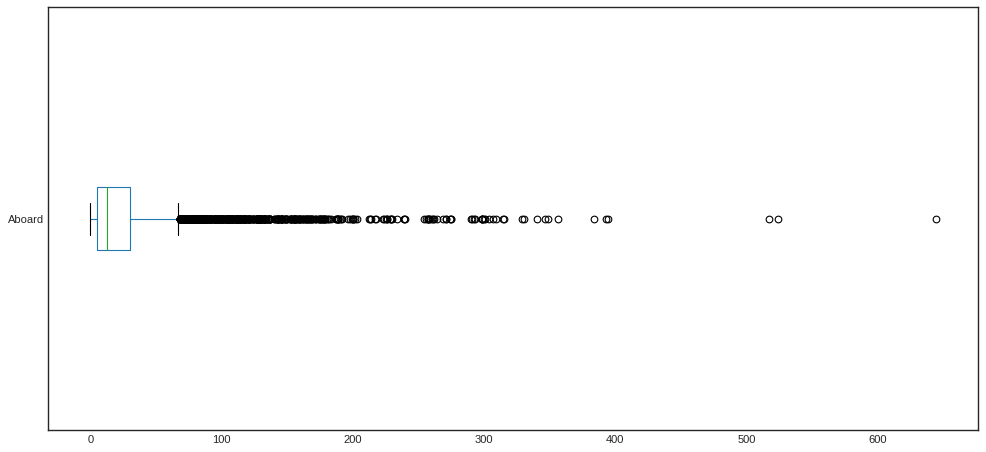

In [ ]:
plt.figure(figsize=(15, 7), dpi=80)
dataset["Aboard"].plot(kind='box', vert=False, fig=(14,10))

# Looking out for survivors
In this sub-section, we analyzed different operators and calculated their survivor count individually and plotted them in the form of a pie chart.


Total survivors:  10767


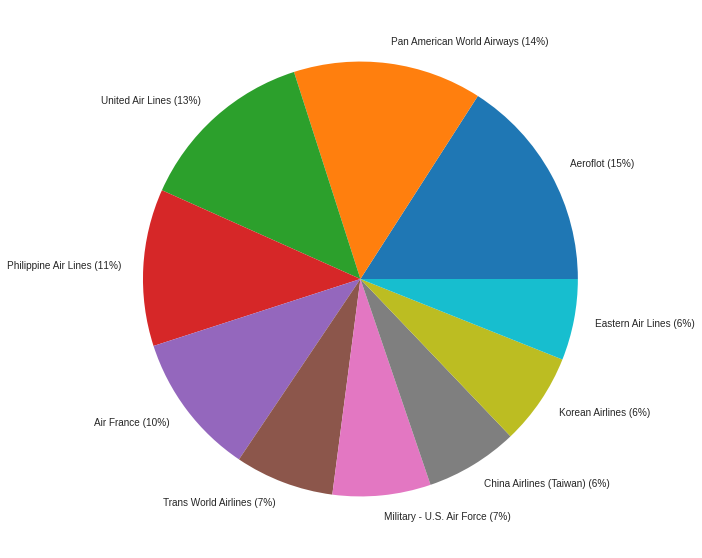

In [ ]:
dataset['Survivors'] = [ a-f for a,f in zip(dataset['Aboard'].tolist(), dataset['Fatalities'].tolist()) ]

survivors_sum = dataset.groupby(['Operator'])['Survivors'].sum()[1:].sort_values(ascending=False)[:10]
total_survivors = int(survivors_sum.sum())

survivor_rates = survivors_sum.transform(lambda x: x/total_survivors*100)
survivor_rates.index = [f'{s[0]} ({int(s[1])}%)' for s in survivor_rates.items()]

print("Total survivors: ", total_survivors)
plt.figure(figsize=(10,10))
survivor_rates.plot(kind='pie', ylabel='')
  

The pie chart shows us that Aeroflot Russian Airlines have had the most survivors till now, closely followed by Pan American World Airways.

# Correlation of the columns with each other

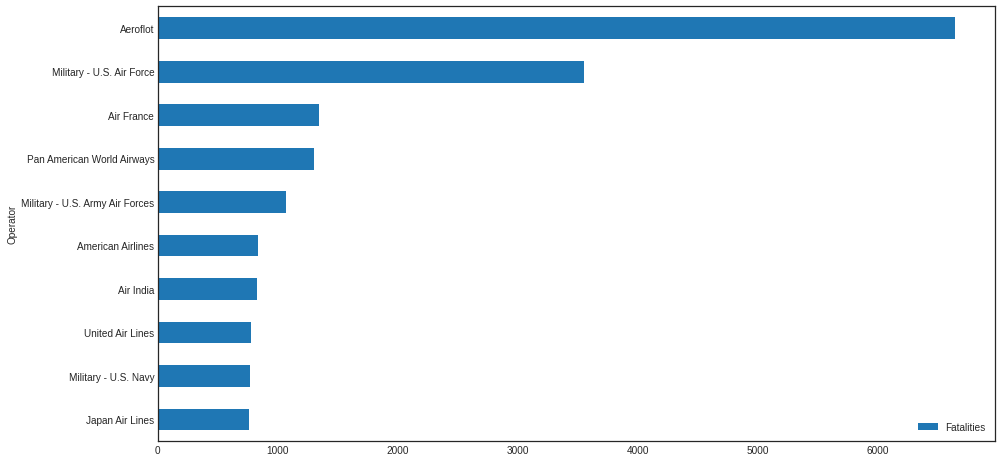

In [ ]:
fatalities_sum = dataset.groupby(['Operator'])['Fatalities'].sum()[1:].sort_values(ascending=False)[:10]
pd.DataFrame(fatalities_sum.sort_values()).plot(kind='barh', figsize=(15,8))

# Regression

Here we find the correlation between passengers aboard and the fatalities caused by the plane crashes. We plotted a regression line on a scatter plot to get the following results.

Estimated coefficients:
b_0 = 6.623527466627877  
b_1 = 0.9854542885334506


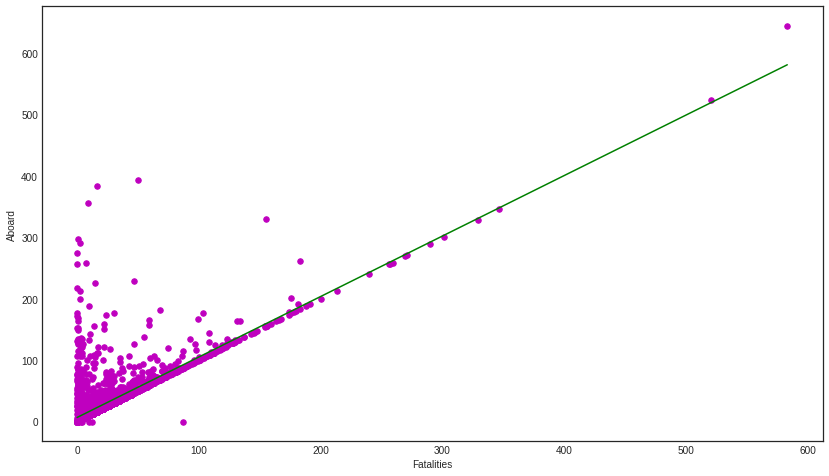

In [ ]:
def findCoefficient(x, y):
    n = np.size(x)
    m_x = np.mean(x)
    m_y = np.mean(y)
    SS_xy = np.sum(y*x) - n*m_y*m_x
    SS_xx = np.sum(x*x) - n*m_x*m_x
    b_1 = SS_xy / SS_xx
    b_0 = m_y - b_1*m_x
 
    return (b_0, b_1)
 
def plotRegressionLine(x, y, b):
    plt.figure(figsize=(14,8))
    plt.scatter(x, y, color = "m",
               marker = "o", s = 30)
    y_pred = b[0] + b[1]*x
    plt.plot(x, y_pred, color = "g")
    plt.xlabel('Fatalities')
    plt.ylabel('Aboard')
    plt.show()

df = dataset[['Fatalities', 'Aboard']].sort_values(by='Aboard')

b = findCoefficient(df['Fatalities'], df['Aboard'])
print("Estimated coefficients:\nb_0 = {}  \nb_1 = {}".format(b[0], b[1]))
plotRegressionLine(x, y, b)

There is a positive relation between the random variables (fatalities and the people aboard).

We can see that if more people are aboard, then approximately all of them will die. Airplanes need to increase safety measures if there are a large number of people aboard. So that the number of fatalities is minimized.


# Making some predictions

Here we create a model to predict how many fatalities a specific crash would have.
We used 80% of the data to train the model, and the rest to predict and compare against actual values.

[8.11133552]
[[0.97839465]]


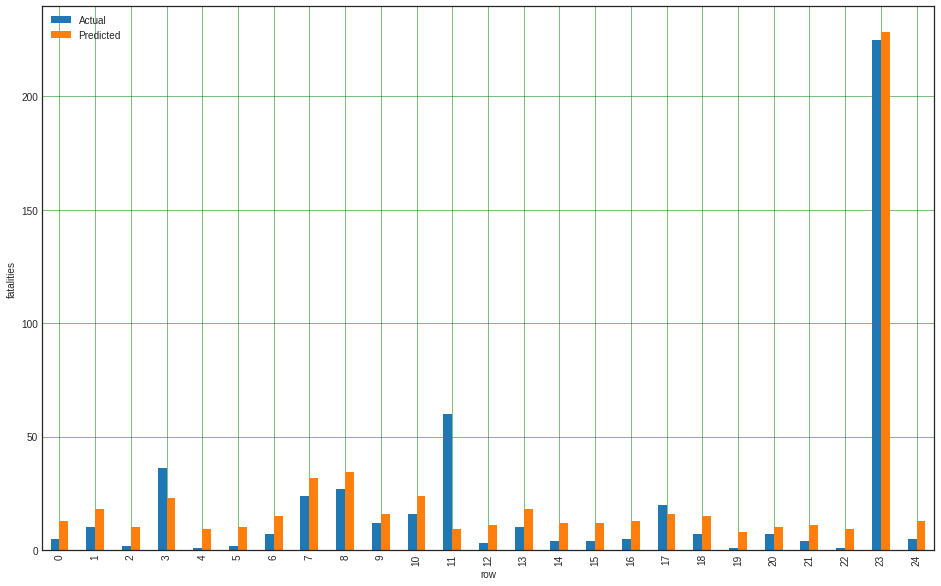

In [ ]:
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics

X = dataset['Fatalities'].values.reshape(-1, 1)
y = dataset['Aboard'].values.reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
regressor = LinearRegression() 

regressor.fit(X_train, y_train)

print(regressor.intercept_)
print(regressor.coef_)

y_pred = regressor.predict(X_test)

df = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
df

df1 = df.head(25)

df1.plot(kind='bar', figsize=(16,10), xlabel='row', ylabel='fatalities')

plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')


plt.show()


The X axis represents the index of a specific crash in the dataframe. The bars show predicted and actual values.
We can see that the model predicts a number close to the passengers aboard the plane, and is close to the actual value most of the times, except in some rare cases.

# ANOVA
In this section, we analyze the variance of the Fatalities, Aboard and Survivors columns, and test whether the means of two or more independent samples are significantly different.

In [ ]:
f = dataset['Fatalities'].tolist()
a = dataset['Aboard'].tolist()
s = dataset['Survivors'].tolist()
stat, p = f_oneway(f,a,s)
if p > 0.05:
  print('Probably the same distribution')
else:
  print('Probably different distributions')

Probably different distributions


As we can see that the means of Fatalities, Aboard and Survivors have different distributions.

# Interactive Viewer for top crashes per year



In this sub-section, you can use the interactive slider to get year-wise fatalities.

In [ ]:
data = {'years': [datetime.strptime(d, "%m/%d/%Y").year for d in dataset["Date"]],
        'fatalities': dataset["Fatalities"]}
df = pd.DataFrame(data).groupby(['years'])['fatalities'].sum()

def slider(year):
  try:
    print(f'Fatalities in {year}: {df[year]}')
  except:
    print(f'Fatalities in {year}: Unknown')
interact(slider, year=(1908,2021), value=2021)





interactive(children=(IntSlider(value=1964, description='year', max=2021, min=1908), Output()), _dom_classes=(…

<function __main__.slider>